In [1]:
# Question Characteristics: 
# Tags, Length of Post, Network Characteristics of user, (to come: Language used)
# Outcome: Time till First Answer, Time till first (good) Answer
# (One week from today, how many answers expected to receive? how many good answers expected to receive?)

In [2]:
import dill
import os
import random
import pandas as pd
from pandas import Series
from sklearn import base, model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

os.chdir('/home/vagrant/projects/stackoverflow-post')
df_tag = dill.load(open('data/df_tag.pkd', 'r'))
centrality = dill.load(open('data/centrality.pkd', 'r'))
top10tags = dill.load(open('data/top10tags.pkd', 'r'))
q_char_est = dill.load(open('est/q_char_est.pkd', 'r'))
tag_rf_est = dill.load(open('est/tag_rf_est.pkd', 'r'))
network_est = dill.load(open('est/network_est.pkd', 'r'))
bag_of_words_est = dill.load(open('est/bag_of_words_est.pkd', 'r'))
full_est = dill.load(open('est/full_est.pkd', 'r'))

In [11]:
dataset = df_tag[np.isfinite(df_tag['fa_time'])]
dataset['top10'] = dataset[top10tags].sum(axis=1)
dataset = dataset.loc[dataset.top10 == 1] #only focus on tags in top 10
dataset = dataset.drop(['top10'], axis = 1)

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
data = dataset.join(centrality, on = 'q_owner') #join network matrix
data['q_day'] = pd.Categorical(data['q_day'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],ordered=True).codes
X = data.loc[:, data.columns != 'fa_time']
y = data.fa_time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [13]:
data.columns

Index([u'fa_score', u'fa_time', u'q_body', u'q_body_len', u'q_date', u'q_day',
       u'q_hour', u'q_owner', u'q_score', u'q_tag', u'q_title', u's10_time',
       u's20_time', u's50_time', u's5_time', u'.net', u'ajax', u'algorithm',
       u'asp.net', u'asp.net-mvc', u'c', u'c#', u'c++', u'css', u'database',
       u'html', u'iphone', u'java', u'javascript', u'jquery', u'linq',
       u'linux', u'multithreading', u'mysql', u'performance', u'php',
       u'python', u'regex', u'ruby', u'ruby-on-rails', u'security', u'sql',
       u'sql-server', u'svn', u'unit-testing', u'vb.net', u'visual-studio',
       u'visual-studio-2008', u'web-services', u'windows', u'winforms', u'wpf',
       u'xml', u'degree', u'in degree', u'out degree', u'degree centrality',
       u'in degree centrality', u'out degree centrality', u'allN', u'outN',
       u'inN', u'avg_n_contact', u'avg_n_in_contact', u'avg_n_out_contact'],
      dtype='object')

In [14]:
bodynames = ['q_body_len', 'q_day', 'q_hour'] #question characteristics
bodyTnames = ['q_body']
tagnames = [u'.net', u'ajax', u'algorithm',
       u'asp.net', u'asp.net-mvc', u'c', u'c#', u'c++', u'css', u'database',
       u'html', u'iphone', u'java', u'javascript', u'jquery', u'linq',
       u'linux', u'multithreading', u'mysql', u'performance', u'php',
       u'python', u'regex', u'ruby', u'ruby-on-rails', u'security', u'sql',
       u'sql-server', u'svn', u'unit-testing', u'vb.net', u'visual-studio',
       u'visual-studio-2008', u'web-services', u'windows', u'winforms', u'wpf',
       u'xml'] #tags of post
nxnames = [u'degree', u'in degree', u'out degree', u'degree centrality',
       u'in degree centrality', u'out degree centrality', u'allN', u'outN',
       u'inN', u'avg_n_contact', u'avg_n_in_contact', u'avg_n_out_contact'] #network centrality of user (who posted questions)

In [15]:
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, col_names):
        self.col_names = col_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.col_names]

class FillNetworkNATransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.fillna(0)
    
class EstimatorTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    def transform(self, X):
        return np.array([self.estimator.predict(X)]).T

class ExtractBodyTextTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self):
        None
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        body = [[p.text for p in BeautifulSoup(html, 'lxml').find_all('p')] for html in X['q_body']]
        bodytext = [''.join(arr) for arr in body]
        return bodytext

In [2]:
# use Random Forest Estimator
md_range = np.arange(2,22,2) #search max_depth = 2:20
msl_range = np.arange(20,35,5) #search min_samples_leaf = 20,25,30,35
ne_range = np.arange(10,40,5) #search n_estimators = 10,15,20,25,30,35
est = RandomForestRegressor()
rf = model_selection.GridSearchCV(
    est, 
    {'max_depth': md_range,
    'min_samples_leaf': msl_range,
    'n_estimators': ne_range},
    cv = 10,
    n_jobs = 5,
    scoring = 'neg_mean_squared_error'
)

In [35]:
#1. question characteristics: body length, post day, post time
cst = ColumnSelectTransformer(bodynames)
x_train = cst.fit_transform(X_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [36]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
q_char_est = Pipeline([
    ('csv', ColumnSelectTransformer(bodynames)),
    ('en', rf.best_estimator_)
])
q_char_est.fit(X_train, y_train)
dill.dump(q_char_est, open('est/q_char_est.pkd', 'w'))

In [38]:
# Tags
cst = ColumnSelectTransformer(tagnames)
x_train = cst.transform(X_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [39]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [ ]:
tag_rf_est = Pipeline([
    ('csv', ColumnSelectTransformer(tagnames)),
    ('en', rf.best_estimator_)
])
tag_rf_est.fit(X_train, y_train)
dill.dump(tag_rf_est, open('est/tag_rf_est.pkd', 'w'))

In [42]:
#3 network centrality
cst = ColumnSelectTransformer(nxnames)
fna = FillNetworkNATransformer()
x_train = cst.transform(X_train)
x_train = fna.transform(x_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
network_est = Pipeline([
    ('csv', ColumnSelectTransformer(nxnames)),
    ('fna', FillNetworkNATransformer()),
    ('en', rf.best_estimator_)
])

In [45]:
network_est.fit(X_train, y_train)
dill.dump(network_est, open('est/network_est.pkd', 'w'))

In [20]:
#3 language
cst = ColumnSelectTransformer(bodyTnames)
ebt = ExtractBodyTextTransformer()
tfidf = TfidfVectorizer(min_df = 30, max_df = 300)

x_train = cst.fit_transform(X_train)
x_train = ebt.fit_transform(x_train)
x_train = tfidf.fit_transform(x_train)
rf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'n_estimators': array([10, 15, 20, 25, 30, 35]), 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]), 'min_samples_leaf': array([20, 25, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=30,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [22]:
bag_of_words_est = Pipeline([
    ('cst', ColumnSelectTransformer(bodyTnames)),
    ('ebt', ExtractBodyTextTransformer()),
    ('tfidf', TfidfVectorizer(min_df = 30, max_df = 300)),
    ('rf', LinearRegression())
])
bag_of_words_est.fit(X_train, y_train)
dill.dump(bag_of_words_est, open('est/bag_of_words_est.pkd', 'w'))

In [23]:
#FULL Estimator
q_char_trans = EstimatorTransformer(q_char_est)
tag_rf_trans = EstimatorTransformer(tag_rf_est)
network_trans = EstimatorTransformer(network_est)
bag_of_words_est_trans = EstimatorTransformer(bag_of_words_est)

In [24]:
union = FeatureUnion([
    ('q_char', q_char_trans),
    ('tag_rf', tag_rf_trans),
    ('network', network_trans),
    ('bag_of_words_est_trans', bag_of_words_est_trans)
])

In [25]:
# union.fit(X)
union.fit(X_train, y_train)

FeatureUnion(n_jobs=1,
       transformer_list=[('q_char', EstimatorTransformer(estimator=Pipeline(steps=[('csv', ColumnSelectTransformer(col_names=['q_body_len', 'q_day', 'q_hour'])), ('en', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_im...ry=None)), ('rf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])))],
       transformer_weights=None)

In [26]:
full_est = Pipeline([
    ('union', union),
    ('blend', RandomForestRegressor())
])
full_est.fit(X_train, y_train)
dill.dump(full_est, open('est/full_est.pkd', 'w'))

In [27]:
pred = full_est.predict(X_train)
real = y_train
# pred = bag_of_words_est.predict(X_test)

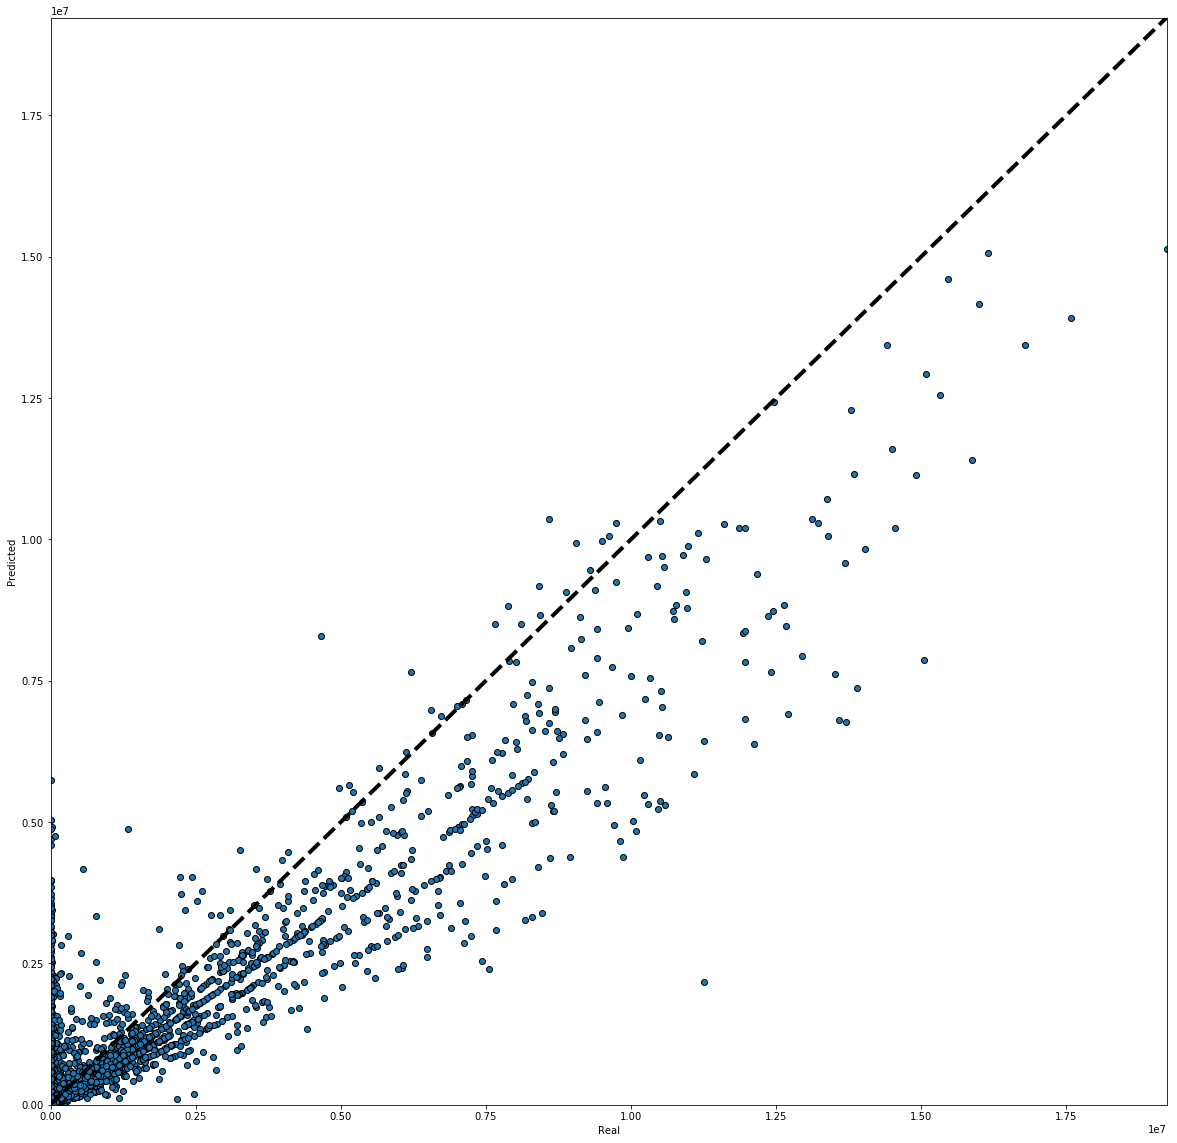

In [28]:
thrh = real.max()
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(real, pred, edgecolors=(0, 0, 0))
ax.plot([real.min(), thrh], [real.min(), thrh], 'k--', lw=4)
ax.set_xlim([real.min(), thrh])
ax.set_ylim([real.min(), thrh])
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
plt.show()

In [31]:
# dill.dump(pred, open('data/pred.pkd', 'w'))
pred = dill.load(open('data/pred.pkd', 'r'))

In [32]:
# evaluate traning performance
from sklearn metrics import mean_absolute_error
explained_variance_score(real, pred)

0.82957509971364429

In [36]:
from sklearn.metrics import r2_score
r2_score(real, pred)

0.82950655077359747

In [44]:
coef = bag_of_words_est.named_steps['rf'].coef_
names = bag_of_words_est.named_steps['tfidf'].get_feature_names()
beta = [(d, coef[i]) for i,d in enumerate(names)]
decrease_top40 = sorted(beta, key = operator.itemgetter(1))[0:40]
increase_top40 = sorted(beta, key = operator.itemgetter(1), reverse = True)[0:40]

In [ ]:
dill.dump(decrease_top40, open('data/decrease_top40.pkd', 'w'))
dill.dump(increase_top40, open('data/increase_top40.pkd', 'w'))

In [49]:
decrease_top40

[(u'shed', -1554039.2669918747),
 (u'lifecycle', -1102514.5886702728),
 (u'injected', -1057689.7760556582),
 (u'hassle', -921071.3326660326),
 (u'decrypt', -863032.07196953392),
 (u'ports', -809837.56844842259),
 (u'tracing', -803028.0256146146),
 (u'charts', -802065.84013972606),
 (u'passwords', -780652.0721025489),
 (u'roles', -769291.20753870986),
 (u'conclusion', -763519.44973878027),
 (u'ultimate', -760894.64780877018),
 (u'happily', -752490.977163804),
 (u'naive', -748915.30532334989),
 (u'switches', -748621.82121054758),
 (u'backwards', -747652.86990594328),
 (u'early', -732783.95548613672),
 (u'reaches', -731880.68101134663),
 (u'funny', -731458.73281633109),
 (u'overall', -730351.37683480466),
 (u'publickeytoken', -711126.59753225395),
 (u'promising', -709543.21271445509),
 (u'17', -708040.57651684969),
 (u'improvement', -692849.03675719304),
 (u'dealt', -691376.90001474903),
 (u'legacy', -688029.58753974421),
 (u'modifications', -687780.60752594471),
 (u'unrelated', -684959.9

In [50]:
increase_top40

[(u'sp2', 3701608.8124176771),
 (u'infrastructure', 3497371.8054280779),
 (u'surface', 3177413.4244603217),
 (u'bindings', 2711725.1027508131),
 (u'conf', 2674545.0240654158),
 (u'presses', 2298169.6580136647),
 (u'formula', 2235669.2264532689),
 (u'recall', 2088509.6955147497),
 (u'stacktrace', 2079681.0012648641),
 (u'thumb', 1918609.2404095659),
 (u'stripped', 1910777.2080717965),
 (u'configuring', 1769509.3981709173),
 (u'checkout', 1744595.5629107794),
 (u'ioc', 1722471.8600886061),
 (u'workstation', 1713043.3763345832),
 (u'material', 1697774.4276975933),
 (u'realised', 1689787.3140642119),
 (u'capturing', 1677429.0657665904),
 (u'cluster', 1665688.0930383434),
 (u'jboss', 1665547.4030652742),
 (u'jpa', 1609235.3685528571),
 (u'drives', 1596798.5503667446),
 (u'nor', 1591293.3102881648),
 (u'channel', 1569073.7959870081),
 (u'velocity', 1548305.5039284758),
 (u'mentions', 1531451.2244384924),
 (u'answering', 1524844.9582781224),
 (u'terminated', 1466445.0866224158),
 (u'binaries'